# Regression Week 5: Feature Selection and LASSO (Interpretation)

In this notebook, you will use LASSO to select features, building on a pre-implemented solver for LASSO (using GraphLab Create, though you can use other solvers). You will:
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.
* Choose best L1 penalty using a validation set, with additional constraint on the size of subset.

In the second notebook, you will implement your own LASSO solver, using coordinate descent. 

In [1]:
import math
import random
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import model_selection
from matplotlib import pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
dtype_dict = {'bathrooms':float, 'waterfront':int, 'sqft_above':int, 'sqft_living15':float, 'grade':int,
              'yr_renovated':int, 'price':float, 'bedrooms':float, 'zipcode':str, 'long':float, 'sqft_lot15':float, 
              'sqft_living':float, 'floors':float, 'condition':int, 'lat':float, 'date':str, 'sqft_basement':int,
              'yr_built':int, 'id':str, 'sqft_lot':int, 'view':int}

sales = pd.read_csv('kc_house_data.csv', dtype=dtype_dict)

# Create new features

As in Week 2, we consider features that are some transformations of inputs.

In [3]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']

# In the dataset, 'floors' was defined with type string, 
# so we'll convert them to float, before creating a new feature.
sales['floors'] = sales['floors'].astype(float) 
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

# Learn regression weights with L1 penalty

Let us fit a model with all the features available, plus the features we just created above.

In [4]:
all_features = pd.Series(['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated'])

Using the entire house dataset, learn regression weights using an L1 penalty of 5e2. Make sure to add "normalize=True" when creating the Lasso object. 

In [5]:
model_all =  linear_model.Lasso(alpha= 5e2, normalize= True)
model_all.fit(sales[all_features], sales['price']) 

Lasso(alpha=500.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Find what features had non-zero weight.

Note that a majority of the weights have been set to zero. So by setting an L1 penalty that's large enough, we are performing a subset selection. 

***QUIZ QUESTION***:
According to this list of weights, which of the features have been chosen? 

In [6]:
model_all.coef_ 

array([    0.        ,     0.        ,     0.        ,   134.43931396,
           0.        ,     0.        ,     0.        ,     0.        ,
           0.        ,     0.        , 24750.00458561,     0.        ,
       61749.10309071,     0.        ,     0.        ,    -0.        ,
           0.        ])

In [7]:
a = pd.Series(model_all.coef_ !=0)

In [8]:
all_features[a]

3     sqft_living
10           view
12          grade
dtype: object

In [31]:
model_all['coefficients'].print_rows(num_rows=18)

TypeError: 'Lasso' object is not subscriptable

In [9]:
a = np.array([1,2,3,4,5])
a[a<3]
c= [1,2,3]
c[1]


2

# Selecting an L1 penalty

To find a good L1 penalty, we will explore multiple values using a validation set. Let us do three way split into train, validation, and test sets. Download the provided csv files containing training, validation and test sets.

In [10]:
testing = pd.read_csv('wk3_kc_house_test_data.csv', dtype=dtype_dict)
training = pd.read_csv('wk3_kc_house_train_data.csv', dtype=dtype_dict)
validation = pd.read_csv('wk3_kc_house_valid_data.csv', dtype=dtype_dict)

Create the 4 features as in #1:



In [11]:
testing['sqft_living_sqrt'] = testing['sqft_living'].apply(sqrt)
testing['sqft_lot_sqrt'] = testing['sqft_lot'].apply(sqrt)
testing['bedrooms_square'] = testing['bedrooms']*testing['bedrooms']
testing['floors_square'] = testing['floors']*testing['floors']

training['sqft_living_sqrt'] = training['sqft_living'].apply(sqrt)
training['sqft_lot_sqrt'] = training['sqft_lot'].apply(sqrt)
training['bedrooms_square'] = training['bedrooms']*training['bedrooms']
training['floors_square'] = training['floors']*training['floors']

validation['sqft_living_sqrt'] = validation['sqft_living'].apply(sqrt)
validation['sqft_lot_sqrt'] = validation['sqft_lot'].apply(sqrt)
validation['bedrooms_square'] = validation['bedrooms']*validation['bedrooms']
validation['floors_square'] = validation['floors']*validation['floors']

Next, we write a loop that does the following:
* For `l1_penalty` in [10^1, 10^1.5, 10^2, 10^2.5, ..., 10^7] (to get this in Python, type `np.logspace(1, 7, num=13)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Compute the RSS on VALIDATION data (here you will want to use `.predict()`) for that `l1_penalty`
* Report which `l1_penalty` produced the lowest RSS on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [12]:
l1_penalties = np.logspace(-1,7,num=13)
#training[all_features]

In [13]:
RSS_array = []
for l1_penalty in l1_penalties:
    #print(l1_penalty)
    model = linear_model.Lasso(alpha= l1_penalty, normalize= True)
    model.fit(training[all_features], training['price'])
    RSS = sum((validation['price'] - model.predict(validation[all_features]))**2)
    RSS_array.append(RSS)
    #print("***")

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [14]:
np.argmin(RSS_array), l1_penalties[np.argmin(RSS_array)], l1_penalties,  RSS_array

(3,
 10.0,
 array([1.00000000e-01, 4.64158883e-01, 2.15443469e+00, 1.00000000e+01,
        4.64158883e+01, 2.15443469e+02, 1.00000000e+03, 4.64158883e+03,
        2.15443469e+04, 1.00000000e+05, 4.64158883e+05, 2.15443469e+06,
        1.00000000e+07]),
 [403459589991008.75,
  403192245817239.25,
  402066410602806.25,
  398213327300133.9,
  410208658629800.2,
  447352172543769.8,
  645898733633801.6,
  1222506859427156.8,
  1222506859427156.8,
  1222506859427156.8,
  1222506859427156.8,
  1222506859427156.8,
  1222506859427156.8])

C:\Users\manje_000\AppData\Local\Programs\Python\Python36\lib\site-packages\matplotlib\axes\_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


(398213327300133.9, 500000000000000.0)

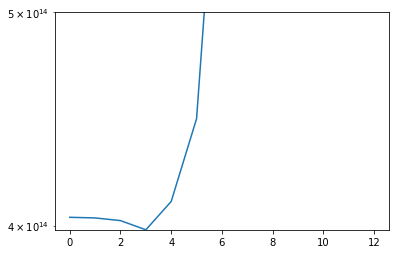

In [15]:
plt.plot(RSS_array)
plt.semilogy()
plt.ylim(0,5e14)

*** QUIZ QUESTION. *** What was the best value for the `l1_penalty`?

In [16]:
10

10

***QUIZ QUESTION***
Also, using this value of L1 penalty, how many nonzero weights do you have?

In [17]:
model = linear_model.Lasso(alpha= 10, normalize= True)
model.fit(training[all_features], training['price'])
model.coef_

array([-1.61445628e+04,  3.73245384e+02,  5.08412433e+04,  6.17853560e+02,
       -4.44113549e+04,  7.85623065e-01, -7.01194765e+02, -0.00000000e+00,
        5.01420046e+03,  6.19488752e+05,  3.80418557e+04,  2.49987718e+04,
        1.28716235e+05,  0.00000000e+00,  0.00000000e+00, -3.29383118e+03,
        1.00573209e+01])

In [18]:
np.count_nonzero(model.intercept_), model.intercept_

(1, 6630155.668628368)

In [19]:
np.count_nonzero(model.coef_) + np.count_nonzero(model.intercept_)

15

# Limit the number of nonzero weights

What if we absolutely wanted to limit ourselves to, say, 7 features? This may be important if we want to derive "a rule of thumb" --- an interpretable model that has only a few features in them.

In this section, you are going to implement a simple, two phase procedure to achive this goal:
1. Explore a large range of `l1_penalty` values to find a narrow region of `l1_penalty` values where models are likely to have the desired number of non-zero weights.
2. Further explore the narrow region you found to find a good value for `l1_penalty` that achieves the desired sparsity.  Here, we will again use a validation set to choose the best value for `l1_penalty`.

Assign 7 to the variable ‘max_nonzeros’.

Exploring large range of l1_penalty

For l1_penalty in np.logspace(1, 4, num=20):


In [20]:
max_nonzeros = 7

## Exploring the larger range of values to find a narrow range with the desired sparsity

Let's define a wide range of possible `l1_penalty_values`:

In [21]:
l1_penalty_values = np.logspace(1, 4, num=20)
l1_penalty_values

array([   10.        ,    14.38449888,    20.69138081,    29.76351442,
          42.81332399,    61.58482111,    88.58667904,   127.42749857,
         183.29807108,   263.66508987,   379.26901907,   545.55947812,
         784.75997035,  1128.83789168,  1623.77673919,  2335.72146909,
        3359.81828628,  4832.93023857,  6951.92796178, 10000.        ])

## Now, implement a loop that search through this space of possible `l1_penalty` values:

Fit a regression model with a given l1_penalty on TRAIN data. Add "alpha=l1_penalty" and "normalize=True" to the parameter list.


In [22]:
nzlist = []
for l1_penalty in l1_penalty_values:
    model = linear_model.Lasso(alpha=l1_penalty, normalize= True)
    model.fit(training[all_features], training['price'])
    #print(model.coef_)
    nzlist.append(np.count_nonzero(model.coef_))
print(nzlist)

[14, 14, 14, 14, 12, 11, 10, 9, 6, 5, 5, 5, 4, 2, 2, 1, 0, 0, 0, 0]


Out of this large range, we want to find the two ends of our desired narrow range of `l1_penalty`.  At one end, we will have `l1_penalty` values that have too few non-zeros, and at the other end, we will have an `l1_penalty` that has too many non-zeros.  

More formally, find:
* The largest `l1_penalty` that has more non-zeros than `max_nonzeros` (if we pick a penalty smaller than this value, we will definitely have too many non-zero weights)
    * Store this value in the variable `l1_penalty_min` (we will use it later)
* The smallest `l1_penalty` that has fewer non-zeros than `max_nonzeros` (if we pick a penalty larger than this value, we will definitely have too few non-zero weights)
    * Store this value in the variable `l1_penalty_max` (we will use it later)


*Hint: there are many ways to do this, e.g.:*
* Programmatically within the loop above
* Creating a list with the number of non-zeros for each value of `l1_penalty` and inspecting it to find the appropriate boundaries.

In [59]:
from math import log10, pow
minv = 1
maxv = 4
nzlist= []
l1_penalty_values = np.logspace(minv, maxv, num=20)
minl1P = l1_penalty_values[0]
maxl2P = l1_penalty_values[19]
zsum = 0
while zsum <18:
    nzlist = []
    for l1_penalty in l1_penalty_values:
        #print(log10(l1_penalty))
        model = linear_model.Lasso(alpha=l1_penalty, normalize= True)
        model.fit(training[all_features], training['price'])
        #print(model.intercept_)
        #print(type(model.coef_))
        nzlist.append(np.count_nonzero(np.append(model.coef_,model.intercept_)))
    print(nzlist)
    nzlist = np.array(nzlist)
    minv = log10(l1_penalty_values[sum(nzlist >7) -1])
    maxv = log10(l1_penalty_values[20 - sum(nzlist <7)]) 
    print (minv, maxv)
    l1_penalty_values = np.logspace(minv, maxv, num=20)
    zsum = sum(nzlist == 7)
#nzli
print ("Minimum L2Penalty: ", round(l1_penalty_values[1],4))
print ("Maximum L2Penalty: ", round(l1_penalty_values[18],4))

[15, 15, 15, 15, 13, 12, 11, 10, 7, 6, 6, 6, 5, 3, 3, 2, 1, 1, 1, 1]
2.1052631578947367 2.4210526315789473
[10, 10, 9, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6]
2.1717451523545703 2.3213296398891967
[8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6]
2.1796180201195505 2.3213296398891967
[8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6]
2.1796180201195505 2.3213296398891967
Minimum L2Penalty:  153.8426
Maximum L2Penalty:  206.0019


In [60]:
minv = log10(l1_penalty_values[18])
maxv = log10(l1_penalty_values[19]) 
print (minv, maxv)
l1_penaltys = np.logspace(minv, maxv, num=20)
print(l1_penalty)
nzlist = []
for l1_penalty in l1_penaltys:
    #print(log10(l1_penalty))
    model = linear_model.Lasso(alpha=l1_penalty, normalize= True)
    model.fit(training[all_features], training['price'])
    #print(model.intercept_)
    #print(type(model.coef_))
    nzlist.append(np.count_nonzero(np.append(model.coef_,model.intercept_)))
print(nzlist)


2.3138711335855313 2.3213296398891967
209.57025406233632
[7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


In [48]:
nzlist[7]

7

In [49]:
l1_penalty_min = minv
l1_penalty_max = maxv

***QUIZ QUESTION.*** What values did you find for `l1_penalty_min` and `l1_penalty_max`, respectively? 

## Exploring the narrow range of values to find the solution with the right number of non-zeros that has lowest RSS on the validation set 

We will now explore the narrow region of `l1_penalty` values we found:

In [50]:
l1_penalty_values = np.linspace(l1_penalty_min,l1_penalty_max,20)


* For `l1_penalty` in `np.linspace(l1_penalty_min,l1_penalty_max,20)`:
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list. When you call `linear_regression.create()` make sure you set `validation_set = None`
    * Measure the RSS of the learned model on the VALIDATION set

Find the model that the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`.

[151.22305943 153.84257003 156.50745622 159.218504   161.97651301
 164.78229669 167.63668262 170.54051269 173.49464338 176.499946
 179.55730697 182.66762805 185.83182661 189.05083595 192.32560549
 195.65710112 199.04630547 202.49421817 206.00185617 209.57025406]
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5


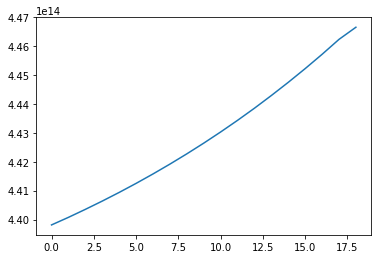

In [51]:
RSS_lst = []
l1_penalties = np.logspace(minv, maxv,20)
print(l1_penalties)
for l1_penalty in l1_penalties[1:20]:
    #print(l1_penalty)
    model = linear_model.Lasso(alpha=l1_penalty, normalize= True)
    model.fit(training[all_features], training['price'])
    RSS = sum((validation['price'] - model.predict(validation[all_features]))**2)
    RSS_lst.append(RSS)
    print(np.count_nonzero(model.coef_))
plt.plot(RSS_lst)    

In [53]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coef_)

    # Get learned parameters as a list
    w = list(model.coef_)

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print ('Learned polynomial for degree ' + str(deg) + ':')
    w.reverse()
    print (np.poly1d(w))

***QUIZ QUESTIONS***
1. What value of `l1_penalty` in our narrow range has the lowest RSS on the VALIDATION set and has sparsity *equal* to `max_nonzeros`?
2. What features in this model have non-zero coefficients?

In [54]:
l1_penalty_final = l1_penalties[1+np.argmin(RSS_lst)]
print('l1_Panelty corresponding minimum RSS on VAlidation Data(for 7 features): ', l1_penalty_final )
#print (" Corresponding Generated Model: ")
model = linear_model.Lasso(alpha=l1_penalty_final, normalize= True)
model.fit(training[all_features], training['price'])
#print_coefficients(model)

a = pd.Series(model.coef_ !=0)
print ("Following features have non-zero coefficient: ")
print(all_features[a])


l1_Panelty corresponding minimum RSS on VAlidation Data(for 7 features):  153.84257002616587
Following features have non-zero coefficient: 
2       bathrooms
3     sqft_living
9      waterfront
10           view
12          grade
15       yr_built
dtype: object
